In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import tensorflow as tf
from tensorflow.keras import layers, models

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler 

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("valentynsichkar/traffic-signs-preprocessed")

print("Path to dataset files:", path)

/Users/hkln4_/tfenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 4.16G/4.16G [24:09<00:00, 3.08MB/s]

Extracting files...


Path to dataset files: /Users/hkln4_/.cache/kagglehub/datasets/valentynsichkar/traffic-signs-preprocessed/versions/2


In [11]:
import os
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))


print(" :", os.listdir(path))

/Users/hkln4_/.cache/kagglehub/datasets/valentynsichkar/traffic-signs-preprocessed/versions/2/test.pickle
/Users/hkln4_/.cache/kagglehub/datasets/valentynsichkar/traffic-signs-preprocessed/versions/2/data0.pickle
/Users/hkln4_/.cache/kagglehub/datasets/valentynsichkar/traffic-signs-preprocessed/versions/2/data2.pickle
/Users/hkln4_/.cache/kagglehub/datasets/valentynsichkar/traffic-signs-preprocessed/versions/2/std_gray.pickle
/Users/hkln4_/.cache/kagglehub/datasets/valentynsichkar/traffic-signs-preprocessed/versions/2/mean_image_rgb.pickle
/Users/hkln4_/.cache/kagglehub/datasets/valentynsichkar/traffic-signs-preprocessed/versions/2/data6.pickle
/Users/hkln4_/.cache/kagglehub/datasets/valentynsichkar/traffic-signs-preprocessed/versions/2/datasets_preparing.py
/Users/hkln4_/.cache/kagglehub/datasets/valentynsichkar/traffic-signs-preprocessed/versions/2/data8.pickle
/Users/hkln4_/.cache/kagglehub/datasets/valentynsichkar/traffic-signs-preprocessed/versions/2/data4.pickle
/Users/hkln4_/.ca

In [13]:
# file path
file_path = "/Users/hkln4_/.cache/kagglehub/datasets/valentynsichkar/traffic-signs-preprocessed/versions/2/data2.pickle"

# Binary modda pickle dosyasını aç
with open(file_path, 'rb') as f:
    data = pickle.load(f, encoding='latin1')  # load as dict type

# one hot encode y_train, y_validation for using in keras
# 43 different label for 43 diff class
data['y_train'] = to_categorical(data['y_train'], num_classes=43)
data['y_validation'] = to_categorical(data['y_validation'], num_classes=43)

# keras's input format: batch_size, height, weight, channels (N, H, W, C)
# making channels come at the end
data['x_train'] = data['x_train'].transpose(0, 2, 3, 1)
data['x_validation'] = data['x_validation'].transpose(0, 2, 3, 1)
data['x_test'] = data['x_test'].transpose(0, 2, 3, 1)

# show the shape of data
print("Shape of data:")
for key, value in data.items():
    if key == 'labels':
        print(f"{key}: {len(value)}")
    else:
        print(f"{key}: {value.shape}")

Shape of data:
y_test: (12630,)
y_validation: (4410, 43)
x_validation: (4410, 32, 32, 3)
x_train: (86989, 32, 32, 3)
y_train: (86989, 43)
labels: 43
x_test: (12630, 32, 32, 3)


* x_train: (86989, 32, 32, 3), 86989 many 32x32 size, 3 channel(RGB) train data

(81, 32, 32, 3)


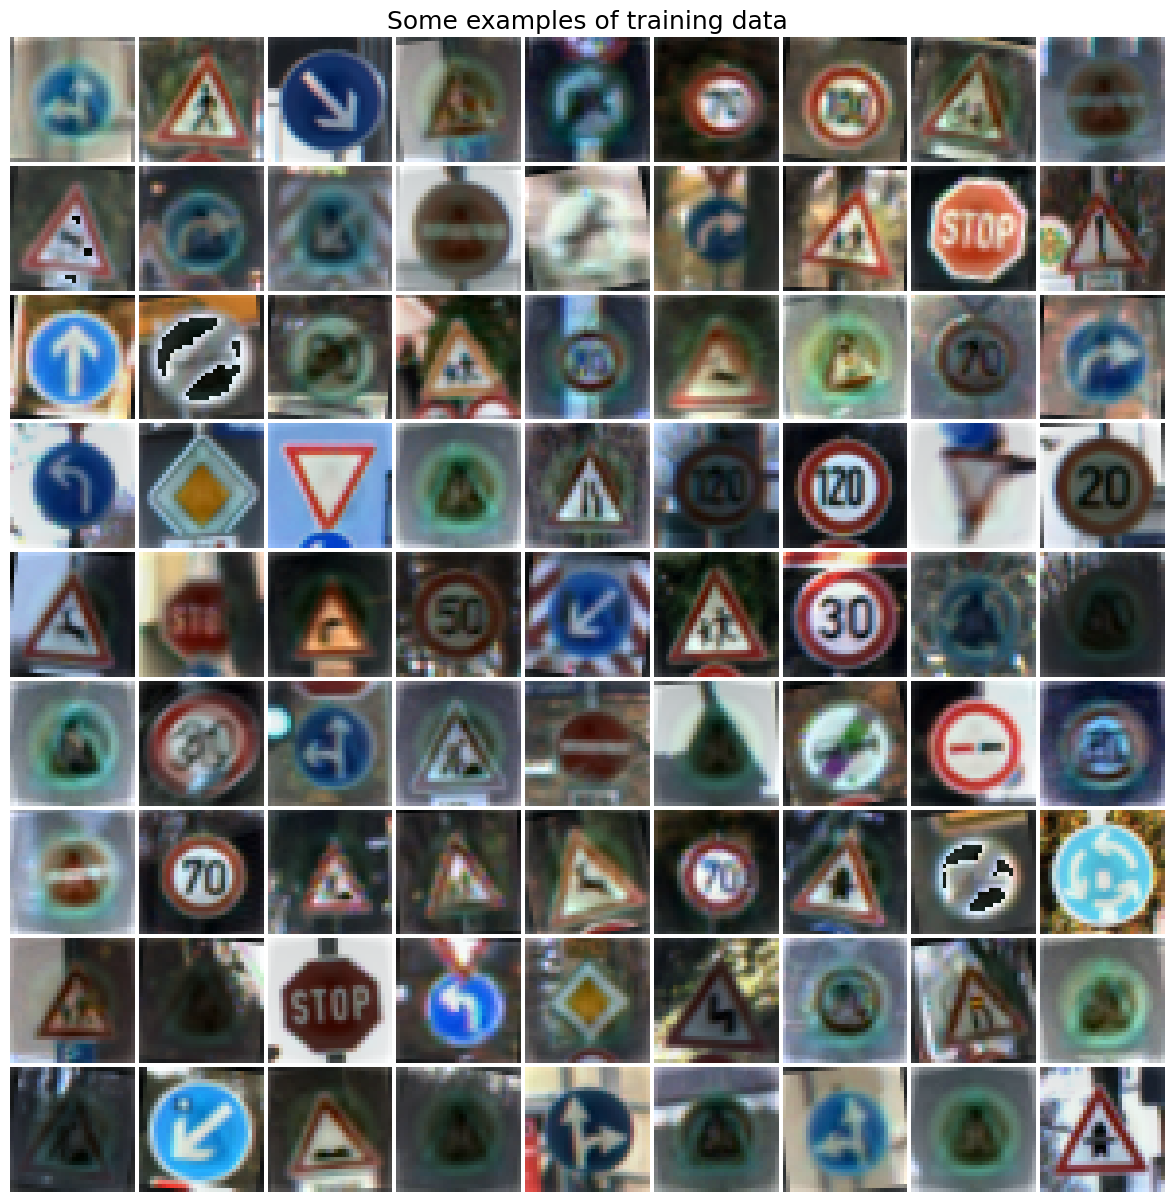

In [15]:
%matplotlib inline

# conver 4D  to 2D grid
# This function takes a batch of images and converts them into a grid format for visualization.
# grid values are normalized to [0, 255] range
def convert_to_grid(x_input):
    N, H, W, C = x_input.shape
    grid_size = int(np.ceil(np.sqrt(N)))
    grid_height = H * grid_size + 1 * (grid_size - 1)
    grid_width = W * grid_size + 1 * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C)) + 255
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = x_input[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = 255.0 * (img - low) / (high - low)
                next_idx += 1
            x0 += W + 1
            x1 += W + 1
        y0 += H + 1
        y1 += H + 1

    return grid


# visualize some examples of training data
# The first 81 images are selected for visualization
examples = data['x_train'][:81, :, :, :]
print(examples.shape)  # (81, 32, 32, 3)

# plot the images
fig = plt.figure()
grid = convert_to_grid(examples)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(15, 15)
plt.title('Some examples of training data', fontsize=18)

# show the plot
plt.show()

# save the plot
fig.savefig('trafficsign_training_examples.png')
plt.close()

In [44]:
#try one model with 3x3 filter
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding= 'same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(43, activation='softmax')
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

/Users/hkln4_/tfenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 500)            │     4,096,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 43)             │        21,543 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,118,939 (15.71 MB)

 Trainable params: 4,118,939 (15.71 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
#overfitting the 3x3 filter model
# The annealer is used to reduce the learning rate when a metric has stopped improving.
epochs = 15
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** (x + epochs))

h = model.fit(data['x_train'][:10], data['y_train'][:10],
            batch_size=5,
            epochs=epochs,
            validation_data=(data['x_validation'][:10], data['y_validation'][:10]),
            shuffle=True,
            callbacks=[annealer],
            verbose=1)

Epoch 1/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.1333 - loss: 3.8159 - val_accuracy: 0.0000e+00 - val_loss: 3.7752 - learning_rate: 4.6329e-04
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.4000 - loss: 3.1945 - val_accuracy: 0.0000e+00 - val_loss: 3.8845 - learning_rate: 4.4013e-04
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6000 - loss: 2.5802 - val_accuracy: 0.0000e+00 - val_loss: 4.0914 - learning_rate: 4.1812e-04
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6000 - loss: 2.1735 - val_accuracy: 0.0000e+00 - val_loss: 4.4316 - learning_rate: 3.9721e-04
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5333 - loss: 1.8592 - val_accuracy: 0.0000e+00 - val_loss: 4.8794 - learning_rate: 3.7735e-04
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6000 - loss: 1.5801 - val_accuracy: 0.0000e+00 - val_loss: 5.3827 - learning_rate: 3.5849e-04
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accura

In [47]:
print('Epochs={0:d}, training accuracy={1:.5f}, validation accuracy={2:.5f}'.\
      format(epochs, max(h.history['accuracy']), max(h.history['val_accuracy'])))

Epochs=15, training accuracy=1.00000, validation accuracy=0.00000


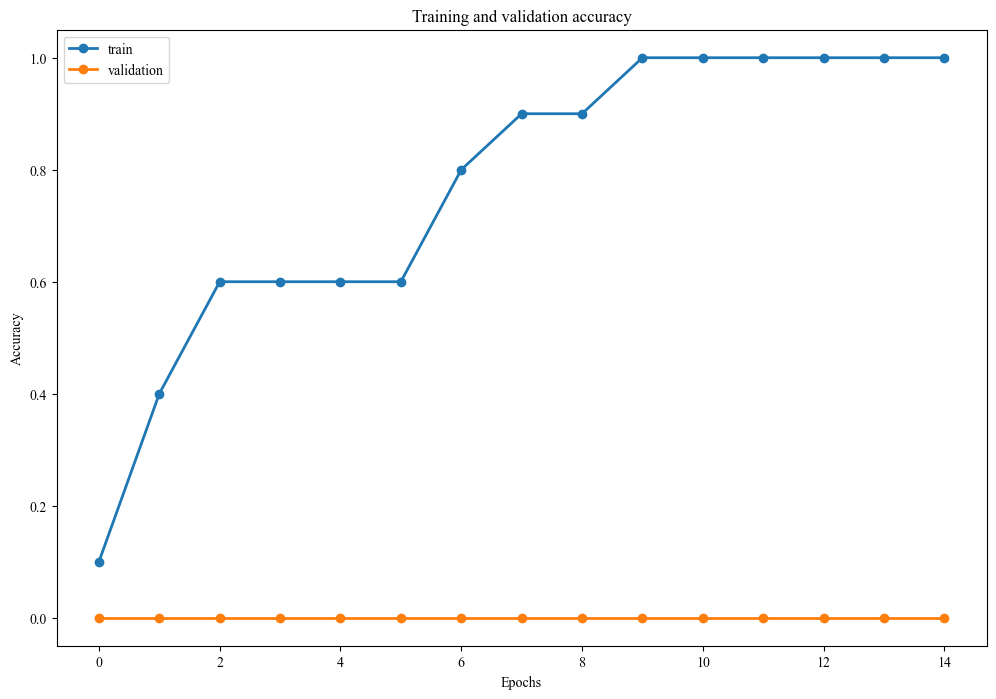

In [55]:
#plotting the results for overfitting
%matplotlib inline
plt.figure(figsize=(12, 8))

plt.plot(h.history['accuracy'],'-o', label='train',linewidth=2)
plt.plot(h.history['val_accuracy'],'-o', label='validation', linewidth=2)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [65]:
import kerastuner
from kerastuner.tuners import Hyperband
from kerastuner.engine.hyperparameters import HyperParameters

def build_model(hp):
    model = keras.Sequential()

    # İlk Konvolüsyon Katmanı
    model.add(layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=16, max_value=64, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
        activation='relu',
        input_shape=(32, 32, 3),
        padding='same'
    ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Opsiyonel İkinci Konvolüsyon Katmanı (küçük aralık)
    model.add(layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values=[3]),
        activation='relu',
        padding='same'
    ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())

    # Dense Katmanı
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
        activation='relu'
    ))

    # Dropout
    model.add(layers.Dropout(
        rate=hp.Float('dropout', min_value=0.2, max_value=0.4, step=0.1)
    ))

    # Çıkış Katmanı
    model.add(layers.Dense(43, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=4,
    factor=3,
    directory='kt_dir',
    project_name='traffic_signs_cnn',
    overwrite=True
)

In [66]:
# Erken durdurma
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Tuning başlat
tuner.search(data['x_train'], data['y_train'],
             epochs=5,
             validation_data=(data['x_validation'], data['y_validation']),
             callbacks=[stop_early])

Trial 10 Complete [00h 01m 44s]
val_accuracy: 0.9442176818847656

Best val_accuracy So Far: 0.9526076912879944
Total elapsed time: 00h 14m 54s


In [67]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

# Test et
val_loss, val_acc = best_model.evaluate(data['x_validation'], data['y_validation'])
print(f"Validation Accuracy: {val_acc:.4f}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 48)     │         3,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 192)            │       786,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         8,299 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 826,283 (3.15 MB)

 Trainable params: 826,283 (3.15 MB)

 Non-trainable params: 0 (0.00 B)

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9530 - loss: 0.1613
Validation Accuracy: 0.9526


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2093297..0.8404453].


(1, 32, 32, 3)
[1]


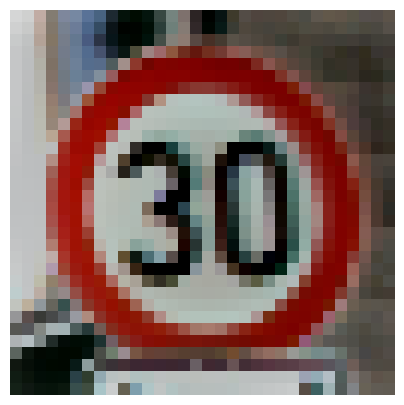

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
(43,)
ClassId: 1
Label: Speed limit (30km/h)


In [84]:
%matplotlib inline

import random

tmp = random.randint(0, len(data['x_test']) - 1)

#predict an image from test dataset
x_input = data['x_test'][tmp:tmp + 1]
print(x_input.shape)

y_input = data['y_test'][tmp:tmp + 1]
print(y_input)

plt.figure(figsize=(5, 5))
plt.imshow(x_input[0, :, :, :])
plt.axis('off')

plt.show()

# getting scores from the input image
scores = best_model.predict(x_input)
print(scores[0].shape)

# getting the class id from the scores
prediction = np.argmax(scores)
print('ClassId:', prediction)

# Defining function for getting texts for every class - labels
def label_text(file):
    # Defining list for saving label in order from 0 to 42
    label_list = []
    
    # Reading 'csv' file and getting image's labels
    r = pd.read_csv(file)
    # Going through all names
    for name in r['SignName']:
        # Adding from every row second column with name of the label
        label_list.append(name)
    
    # Returning resulted list with labels
    return label_list


# Getting labels
labels = label_text('/Users/hkln4_/.cache/kagglehub/datasets/valentynsichkar/traffic-signs-preprocessed/versions/2/label_names.csv')

# Printing label for classified Traffic Sign
print('Label:', labels[prediction])

In [82]:
#all labels
for i in range(len(labels)):
    print(i+1,': ', labels[i])

1 :  Speed limit (20km/h)
2 :  Speed limit (30km/h)
3 :  Speed limit (50km/h)
4 :  Speed limit (60km/h)
5 :  Speed limit (70km/h)
6 :  Speed limit (80km/h)
7 :  End of speed limit (80km/h)
8 :  Speed limit (100km/h)
9 :  Speed limit (120km/h)
10 :  No passing
11 :  No passing for vehicles over 3.5 metric tons
12 :  Right-of-way at the next intersection
13 :  Priority road
14 :  Yield
15 :  Stop
16 :  No vehicles
17 :  Vehicles over 3.5 metric tons prohibited
18 :  No entry
19 :  General caution
20 :  Dangerous curve to the left
21 :  Dangerous curve to the right
22 :  Double curve
23 :  Bumpy road
24 :  Slippery road
25 :  Road narrows on the right
26 :  Road work
27 :  Traffic signals
28 :  Pedestrians
29 :  Children crossing
30 :  Bicycles crossing
31 :  Beware of ice/snow
32 :  Wild animals crossing
33 :  End of all speed and passing limits
34 :  Turn right ahead
35 :  Turn left ahead
36 :  Ahead only
37 :  Go straight or right
38 :  Go straight or left
39 :  Keep right
40 :  Keep l